<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 1: Standardized Test Analysis

## Data Import and Cleaning

For more details refer to the data cleaning [notebook](03_Visualization.ipynb).



## Sources

I consulted these articles to figure out the setup for using geoPanda: 
- "why you should be using geopandas" [medium article](https://medium.com/@minaienick/why-you-should-be-using-geopandas-to-visualize-data-on-maps-aka-geo-visualization-fd1e3b6211b4)
- "mapping US states" [medium article](https://medium.com/@erikgreenj/mapping-us-states-with-geopandas-made-simple-d7b6e66fa20d)
- geopandas and matplotlib [towards-data-science article](https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d)
- "Defining boundaries" [stack exchange post](https://gis.stackexchange.com/questions/281949/how-to-define-boundary-numbers-without-decimal-points-geopandas)
- geopandas user guides [docs 1](https://geopandas.org/docs/user_guide/mapping.html), [docs 2](https://geopandas.org/docs/user_guide.html)
- reduce legend size [stack overflow post](https://stackoverflow.com/questions/54236083/geopandas-reduce-legend-size-and-remove-white-space-below-map)
- legends filled with slash lines [stack overflow post](https://stackoverflow.com/questions/57067623/geopandas-plotting-with-legend-filled-up-with-slash-lines)



```bash
sudo tlmgr install type1cm
sudo tlmgr install dvipng
```

In [1]:
# environment variables

state_maps_fname = '../data/maps/states/states.shp'
cleaned_data_path = '../data/cleaned'
images_path = '../images'

In [2]:
# imports 
import pandas as pd
import numpy as np
import copy
import ast

# plot imports
import matplotlib.pyplot as plt
import geopandas as gpd  
from shapely.geometry import Point, Polygon
from matplotlib.lines import Line2D
import seaborn as sns
from shapely import affinity

%matplotlib inline

In [3]:
# enable latex

plt.rcParams.update({
    "text.usetex": True,
})



In [4]:
# read the us state maps
usa0 = gpd.read_file(state_maps_fname);

In [5]:
# Adjust Alaska and Hawaii
def reposition_states(gdf):
    col = 'STATE_NAME'  # update if needed
    alaska = gdf[gdf[col].str.contains('Alaska', case=False)].copy()
    hawaii = gdf[gdf[col].str.contains('Hawaii', case=False)].copy()
    mainland = gdf[~gdf[col].str.contains('Alaska|Hawaii', case=False)].copy()

    # Alaska: scale and move
    alaska.geometry = alaska.geometry.apply(lambda geom:
        affinity.translate(
            affinity.scale(geom, xfact=0.35, yfact=0.35, origin='center'),
            xoff=4.5e6, yoff=-1.5e6
        )
    )

    # Hawaii: move
    hawaii.geometry = hawaii.geometry.apply(lambda geom:
        affinity.translate(geom, xoff=5.5e6, yoff=-1.0e6)
    )

    return gpd.GeoDataFrame(pd.concat([mainland, alaska, hawaii], ignore_index=True), crs=gdf.crs)


# Reposition and plot
# Reproject if needed
if usa0.crs.to_epsg() == 4326:  # WGS84 (degrees)
    usa0 = usa0.to_crs("EPSG:2163")  # Projected in meters

# Assign if missing
if usa0.crs is None:
    usa0.set_crs("EPSG:4326", inplace=True)  # common default

# Then project to meters
usa0 = usa0.to_crs("EPSG:2163")
usa = reposition_states(usa0)

In [6]:
# prepare sat and act scores to be plotted

def get_plot_ready_sat_and_act(path = cleaned_data_path):
    """
    Read in the already cleaned data and make it ready to be plotted on maps.
    
    """
    df = pd.read_csv(f'{path}/act_and_sat.csv')
    
    # add participation percentages to be plotted
    for test in ['sat', 'act']:
        df[f'{test.upper()} Participation %'] = 100 * df[f'{test}_participation']

    # take the average over the years for each state
    df_average = df.set_index('year').groupby('state').mean().reset_index()
    
    
    # during the previous process, the types of 'test_mandatory' have changed - change them back to boolean
    for test in ['sat', 'act']:
        df_average[f'{test}_mandatory'] = df_average[f'{test}_mandatory'].astype(bool)

    return df_average


def merge_df_with_map(df, base_geo = usa, state_field = 'state'):
    """
    Merge the given dataframe with the base geo table
    """
    return pd.merge(base_geo, df.rename(columns={state_field: 'STATE_NAME'}), on='STATE_NAME')



def view_table_for_state_and_total_scores(act_and_sat, test='sat'):
    out = act_and_sat.copy()
    out['act_total'] = out['act_composite']
    out = out.sort_values(f'{test}_total', ascending=False)[['state', f'{test}_total']].reset_index()
    out.drop(columns='index', inplace=True)
    out[f'{test}_total'] = out[f'{test}_total'].astype(int) if test == 'sat' else round(out[f'{test}_total'], 1)
    return out

def view_table_for_state_and_participation_rates(act_and_sat, test='sat'):
    out = act_and_sat.sort_values(f'{test}_participation', ascending=False)[['state', f'{test.upper()} Participation %']].reset_index()
    out.drop(columns='index', inplace=True)
    out[f'{test.upper()} Participation %'] = out[f'{test.upper()} Participation %'].astype(int)
    out.rename(columns = {f'{test.upper()} Participation %': f'{test} %'}, inplace=True)
    return out

def view_table_for_median_acceptance_scores(acceptance_scores, test = 'sat'):
    out = acceptance_scores.sort_values(f'{test}_median', ascending=False)[['state', f'{test}_median']].reset_index()
    out.dropna(inplace=True)
    out.drop(columns='index', inplace=True)
    out[f'{test}_median'] = out[f'{test}_median'].astype(int) if test == 'sat' else round(out[f'{test}_median'], 1)
    return out

def get_counts_for_high_ranking_universities_per_state(path=cleaned_data_path):
    df = pd.read_csv(f'{path}/high_ranking_colleges_with_coordinates.csv')
    return df['state'].value_counts()


def convert_coordinates_to_geopandas_df(fname, path=cleaned_data_path):
    
    df = pd.read_csv(f'{path}/{fname}')
    df = df[~df['coordinates'].isnull()]
    ## Getting the coordinates - convert the string tuples to tuples
    coordinates = [ast.literal_eval(x) for x in df['coordinates']]
    geometry = [Point(x[1], x[0]) for x in coordinates]
    
    ## add the geometry column to hour table
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)
    
    return geo_df


def get_acceptance_scores_ready_for_plotting(path=cleaned_data_path):
    df = pd.read_csv(f'{path}/sat_act_by_college_in_states.csv')
    #median_acceptance_score_by_average_of_universities_in_states 
    acceptance_scores = df.groupby('state')[['sat_median', 'act_median']].mean()
    acceptance_scores.reset_index(inplace=True)
    geo_acceptance_scores = pd.merge(usa, acceptance_scores.rename(columns={'state': 'STATE_NAME'}), on='STATE_NAME')
    return acceptance_scores, geo_acceptance_scores



    
def get_min_acceptance_score_compared_to_state_scores(path=cleaned_data_path):
    req_scores_state_avg = pd.read_csv(f'{path}/req_scores_state_averages.csv')
    req_scores_state_avg['high_sat_req'] = req_scores_state_avg['sat_min']>req_scores_state_avg['sat_total']
    req_scores_state_avg['high_act_req'] = req_scores_state_avg['act_min']>req_scores_state_avg['act_total']

    #req_scores_state_avg.iloc[req_scores_state_avg['sat_min'].isnull(), 1:] = np.nan

    #
    # Identify rows where 'sat_min' is null
    null_mask = req_scores_state_avg['sat_min'].isnull()
    
    # Get the target columns (everything from column 1 onward)
    target_cols = req_scores_state_avg.columns[1:]
    
    # Cast all target columns to float (safe for np.nan)
    req_scores_state_avg[target_cols] = req_scores_state_avg[target_cols].astype('float')
    
    # Set those rows to np.nan
    req_scores_state_avg.loc[null_mask, target_cols] = np.nan

    #
    geo_req_scores_state_avg = pd.merge(usa, req_scores_state_avg.rename(columns={'state': 'STATE_NAME'}), on='STATE_NAME')
    return geo_req_scores_state_avg


def get_states_where_colleges_require_higher_score_than_average(path=cleaned_data_path, test='sat'):
    req_scores_state_avg = pd.read_csv(f'{path}/req_scores_state_averages.csv')
    req_scores_state_avg[f'high_{test}_req'] = req_scores_state_avg[f'{test}_min']>req_scores_state_avg[f'{test}_total']
    out = req_scores_state_avg[req_scores_state_avg[f'high_{test}_req']==True][['state']].reset_index().drop(columns='index')
    return out


In [7]:
def plot_all_universities_on_states(usa, geo_universities, to_save=False,
                                                            figsize = (16, 16), 
                                                            title_coords=(0.5, 0.95),
                                                            subtitle_coords=(0.5, 0.89),
                                                            marker_color='brown',
                                                            marker = 'o',
                                                            dataset_coords = (.25, .2)
                                                            ):
    
    n = geo_universities.shape[0]
    
    title = f'Universities'
    subtitle = f'count: {n}'
    
    fig, ax = plt.subplots(figsize=figsize)
    
    usa.plot(ax=ax, color='.9', edgecolor='white', linewidth=1)
    
    # plot the locations of the top ranking universities as markers
    geo_universities['geometry'].plot(ax=ax, markersize = 10, color = marker_color, marker = marker, alpha=.4)
    
    ax.annotate(title,
            xy=title_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=24)
    
    ax.set_aspect('equal')
    # remove the axes
    ax.set_axis_off()
    if to_save:
        plt.savefig(f'{images_path}/all_universities_map.png', bbox_inches='tight', dpi=300)



In [8]:
def plot_top_ranking_universities_on_states(usa, geo_top_ranking, to_save=False,
                                                            figsize = (16, 16), 
                                                            title_coords=(0.5, 0.95),
                                                            subtitle_coords=(0.5, 0.89),
                                                            marker_color='b',
                                                            marker = 'o',
                                                            source_coords = (.01, .01), 
                                                            alpha=0.8
                                                            ):
    
    title = f'Top 100 Universities'
    subtitle = '(2020)'
    source_website = 'https://www.topuniversities.com'
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    
    usa.plot(ax=ax, color='.9', edgecolor='white', linewidth=1)
    
    # plot the locations of the top ranking universities as markers
    geo_top_ranking['geometry'].plot(ax=ax, markersize = 10, color = marker_color, marker = marker, alpha=1)
    
    ax.annotate(title,
            xy=title_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=24)
    ax.annotate(subtitle,
            xy=subtitle_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=15)
    
    ax.annotate(f'source: {source_website}',
            xy=source_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center',
            color='#555555',
            fontsize=10)
    
    ax.set_axis_off()
    if to_save:
        plt.savefig(f'{images_path}/top_ranking_map.png', bbox_inches='tight', dpi=300)


In [9]:
def plot_top_ranking_universities_layered_on_average_participation(geo_participation, geo_top_ranking, test = 'sat', to_save=False,
                                                                   figsize = (16, 16), 
                                                                    title_coords=(0.5, 0.95),
                                                                    subtitle_coords=(0.5, 0.89),
                                                                   alpha = .6,
                                                                   cmap='Greys',
                                                                   marker_color='b',
                                                                   marker = 'o'
                                                                  ):
    
    participation_field = f'{test.upper()} Participation %'
    title = r'Average $\bf{%s}$ Participation Rate by State'%test.upper()
    subtitle = '(2017, 2018, 2019)'
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    
    # colorbar parameters
    legend_kwds = {
        'shrink': 0.2, 
        'orientation': "horizontal", 
        'pad': 0, 
        'alpha': alpha, 
        'label': '%', 
        'location': 'bottom'
        }
    
    # missing value legend parameters
    missing_kwds = {
        'color': 'lightgrey',
        "hatch": "///",
        "edgecolor": "red",
        "label": "Missing values"
    }
    
    # plot participation rates - they show in different gradients of color on states
        
    geo_participation.plot(ax=ax, 
            column=participation_field, 
            cmap=cmap, 
            edgecolor='.8', 
            linewidth=.8, 
            legend=True, 
            alpha=alpha, 
            vmin=0, vmax=100,
            legend_kwds=legend_kwds, 
            missing_kwds=missing_kwds)

    
    # plot the locations of the top ranking universities as markers
    geo_top_ranking['geometry'].plot(ax=ax, markersize = 10, color = marker_color, marker = marker, alpha=alpha)
    
    ax.annotate(title,
            xy=title_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=24)
    ax.annotate(subtitle,
            xy=subtitle_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=15)
    

    
    # add a legend for these markers
    LegendElement = [Line2D([0],[0],color=marker_color, marker=marker,label='Top 100 Universities', lw=0)]
    ax.legend(handles=LegendElement,loc='lower center', frameon=False, fontsize=15)
    
    # remove the axes
    ax.set_axis_off()
    if to_save:
        plt.savefig(f'{images_path}/{test}_participation_and_top_ranking_map.png', bbox_inches='tight', dpi=300)


In [10]:
def plot_top_ranking_universities_layered_on_average_participation_with_mandatory(geo_participation, geo_top_ranking, test = 'sat', to_save=False,
                                                                   figsize = (16, 16), 
                                                                    title_coords=(0.5, 0.95),
                                                                    subtitle_coords=(0.5, 0.89),
                                                                   alpha = .6,
                                                                   cmap='Greys',
                                                                   marker_color='b',
                                                                   marker= 'o',
                                                                  line_color='orange'
                                                                  ):
    
    participation_field = f'{test.upper()} Participation %'
    mandatory_test_field = f'{test}_mandatory'
    geo_is_mandatory = geo_participation[geo_participation[mandatory_test_field]==True]
    title = r'Average $\bf{%s}$ Participation Rate by State'%test.upper()
    subtitle = '(2017, 2018, 2019)'
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    
    # colorbar parameters
    legend_kwds = {
        'shrink': 0.2, 
        'orientation': "horizontal", 
        'pad': 0, 
        'alpha': alpha, 
        'label': '%', 
        'location': 'bottom'
        }
    
    # missing value legend parameters
    missing_kwds = {
        'color': 'lightgrey',
        "hatch": "///",
        "edgecolor": "red",
        "label": "Missing values"
    }
    
    # plot participation rates - they show in different gradients of color on states
        
    geo_participation.plot(ax=ax, 
            column=participation_field, 
            cmap=cmap, 
            edgecolor='.8', 
            linewidth=.8, 
            legend=True, 
            alpha=alpha, 
            vmin=0, vmax=100,
            legend_kwds=legend_kwds, 
            missing_kwds=missing_kwds)
    
    geo_is_mandatory.plot(ax=ax, 
            edgecolor=line_color, 
            linewidth=.9, 
            facecolor="none",
            legend=True, 
            alpha=1, 
)

    
    # plot the locations of the top ranking universities as markers
    geo_top_ranking['geometry'].plot(ax=ax, markersize = 10, color = marker_color, marker = marker, alpha=.4)
    
    ax.annotate(title,
            xy=title_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=24)
    ax.annotate(subtitle,
            xy=subtitle_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=15)
    

    
    # add a legend for these markers
    LegendElement = [
        Line2D([0],[0],color='orange',label='Mandatory Test', lw=2),
        Line2D([0],[0],color=marker_color, marker=marker,label='Top 100 Universities', lw=0),
    ]
    ax.legend(handles=LegendElement,loc='lower center', frameon=False, fontsize=15)
    
    # remove the axes
    ax.set_axis_off()
    if to_save:
        plt.savefig(f'{images_path}/{test}_participation_and_top_ranking_map_mandatory.png', bbox_inches='tight', dpi=300)


In [11]:
def average_score_with_mandatory(geo_participation, test = 'sat', to_save=False,
                                                                   figsize = (16, 16), 
                                                                    title_coords=(0.5, 0.95),
                                                                    subtitle_coords=(0.5, 0.89),
                                                                   alpha = .8,
                                                                   cmap='Blues',
                                                                   marker_color='b',
                                                                   marker= 'o',
                                                                  line_color='orange'
                                                                  ):
    
    score_field = f'{test}_total' if test == 'sat' else f'{test}_composite'
#     vmin, vmax = (400, 1600) if test == 'sat' else (1, 36)
        
    mandatory_test_field = f'{test}_mandatory'
    geo_is_mandatory = geo_participation[geo_participation[mandatory_test_field]==True]
    
    title = r'Average Total $\bf{%s}$ Score'%test.upper()
    subtitle = '(2017, 2018, 2019)'
    
    fig, ax = plt.subplots(figsize=figsize)
    
        
    geo_participation.plot(ax=ax, 
            column=score_field, 
            scheme='quantiles',
            k = 4,
            cmap=cmap, 
            edgecolor='.8', 
            linewidth=.9, 
            legend=True, 
            alpha=alpha, 
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(.2, .3)}
            )
    
    geo_is_mandatory.plot(ax=ax, 
            edgecolor=line_color, 
            linewidth=.5, 
            facecolor="none",
            legend=False, 
            alpha=1, 
)

    
    ax.annotate(title,
            xy=title_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=24)
    ax.annotate(subtitle,
            xy=subtitle_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=15)
    
    
    ax.set_aspect('equal')

    # remove the axes
    ax.set_axis_off()
    if to_save:
        plt.savefig(f'{images_path}/{test}_score_map_mandatory.png', bbox_inches='tight', dpi=300)


In [12]:
def average_score_with_mandatory_mod(geo_participation, test = 'sat', to_save=False,
                                                                   figsize = (16, 16), 
                                                                title_coords=(0.5, 0.95),
                                                                subtitle_coords=(0.5, 0.89),
                                                                   alpha = .8,
                                                                   cmap='Blues',
                                                                   marker_color='b',
                                                                   marker= 'o',
                                                                  line_color='orange'
                                                                  ):
    
    score_field = f'{test}_total' if test == 'sat' else f'{test}_composite'
#     vmin, vmax = (400, 1600) if test == 'sat' else (1, 36)
        
    mandatory_test_field = f'{test}_mandatory'
    geo_is_mandatory = geo_participation[geo_participation[mandatory_test_field]==True]
    
    title = r'Average Total $\bf{%s}$ Score'%test.upper()
    subtitle = '(2017, 2018, 2019)'
    
    fig, ax = plt.subplots(figsize=figsize)

    
    
    legend_kwds = {
        'shrink': 0.2, 
        'orientation': "horizontal", 
        'pad': 0, 
        'alpha': alpha, 
        'location': 'bottom'
        }
        
    geo_participation.plot(ax=ax, 
            column=score_field, 
#             scheme='quantiles',
#             k = 4,
            cmap=cmap, 
            edgecolor='.8', 
            linewidth=.9, 
            legend=True, 
            alpha=alpha, 
            legend_kwds=legend_kwds,
            )
    
    geo_is_mandatory.plot(ax=ax, 
            edgecolor=line_color, 
            linewidth=.5, 
            facecolor="none",
            legend=False, 
            alpha=1, 
)

    
    ax.annotate(title,
            xy=title_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=24)
    ax.annotate(subtitle,
            xy=subtitle_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=15)
    

    LegendElement = [
        Line2D([0],[0],color='orange',label='Mandatory Test', lw=2),
    ]
    ax.legend(handles=LegendElement,loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, fontsize=15)
    ax.set_aspect('equal')

    # remove the axes
    ax.set_axis_off()
    if to_save:
        plt.savefig(f'{images_path}/{test}_score_map_mandatory_mod.png', bbox_inches='tight', dpi=300, pad_inches=0)

In [13]:
def plot_scores_vs_participation(act_and_sat, to_save = False):
    
    f = plt.figure(figsize=(16, 8))
    gs = f.add_gridspec(1, 2)

    sns.set_theme(style="white", palette="pastel")
    sns.set_context("talk")

    ax = f.add_subplot(gs[0, 0])

    sns.scatterplot(data=act_and_sat, x="SAT Participation %", y="sat_total", hue="sat_mandatory", palette="Set2", alpha = 1, legend=False);
    ax.set(ylabel='Total Score', title='SAT', xlabel='Participation %', xlim=(-1,101))

    ax = f.add_subplot(gs[0, 1])

    p = sns.scatterplot(data=act_and_sat, x="ACT Participation %", y="act_composite", hue="act_mandatory", palette="Set2", alpha = 1);
    ax.set(ylabel='', title='ACT', xlabel='Participation %', xlim=(-1,101))
    p.legend(title="Is the test mandatory?", frameon=False)
    sns.despine(right=True)
    
    if to_save:
        plt.savefig(f'{images_path}/score_vs_participation.png', bbox_inches='tight', dpi=300)
        

In [14]:
def acceptance_scores_on_states(geo_acceptance_scores, test = 'sat', to_save=False,
                                                                   figsize = (16, 16), 
                                                                    title_coords=(0.5, 0.95),
                                                                   alpha = .8,
                                                                   cmap='Greens',
                                                                  ):
    
    score_field = f'{test}_median'

    
    title = r'Required (Median) $\bf{%s}$ Score by Universities'%test.upper()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    
    
    # missing value legend parameters
    missing_kwds = {
        'color': 'lightgrey',
        "hatch": "///",
        "edgecolor": "red",
        "label": "Missing values"
    }
    
    # plot participation rates - they show in different gradients of color on states
        
    geo_acceptance_scores.plot(ax=ax, 
            column=score_field, 
            scheme='quantiles',
            k = 4,
            cmap=cmap, 
            edgecolor='.8', 
            linewidth=.9, 
            legend=True, 
            alpha=alpha, 
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(.2, .3)
#                          'bbox_to_anchor':(.2,0.5)
                        }
                          )
    


    
    ax.annotate(title,
            xy=title_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=24)
    

    ax.set_aspect('equal')

    # remove the axes
    ax.set_axis_off()
    if to_save:
        plt.savefig(f'{images_path}/{test}_required_scores.png', bbox_inches='tight', dpi=300)


In [15]:
def map_states_with_higher_than_state_average_req(usa, geo_req_scores_state_avg, test='sat', to_save=False,
                                                            figsize = (16, 16), 
                                                                title_coords=(0.5, 0.95),
                                                                subtitle_coords=(0.5, 0.89),
                                                            line_color='purple',
                                                            marker = 'o',
                                                            dataset_coords = (.25, .2)
                                                            ):
    
    
    title = r'States Where the Minimum $\bf{%s}$ Requirement'%test.upper()
    subtitle =  'is Higher than the State Average Score'
    
    field = f'high_{test}_req'
    
    high_states = geo_req_scores_state_avg[geo_req_scores_state_avg[field]==True]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    
    usa.plot(ax=ax, color='.9', edgecolor='white', linewidth=1)
    
    high_states.plot(ax=ax, 
            edgecolor=line_color, 
            linewidth=.9, 
            facecolor="none",
            legend=True, 
            alpha=1, 
    )
    
    ax.annotate(title,
            xy=title_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=24)
    ax.annotate(subtitle,
            xy=subtitle_coords,  
            xycoords='axes fraction', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=24)
    
    
    ax.set_aspect('equal')
    # remove the axes
    ax.set_axis_off()
    if to_save:
        plt.savefig(f'{images_path}/{test}_higher_than_average_min_req.png', bbox_inches='tight', dpi=300)


In [16]:
from shapely import affinity

from shapely import affinity

def reposition_university_points(gdf):
    gdf = gdf.copy()

    # Reposition Hawaii
    hawaii = gdf[gdf['STATE_NAME'] == 'Hawaii'].copy()
    hawaii.geometry = hawaii.geometry.apply(lambda geom: 
        affinity.translate(geom, xoff=5.5e6, yoff=-1.0e6)
    )

    # Reposition Alaska
    alaska = gdf[gdf['STATE_NAME'] == 'Alaska'].copy()
    alaska.geometry = alaska.geometry.apply(lambda geom:
        affinity.translate(
            affinity.scale(geom, xfact=0.35, yfact=0.35, origin='center'),
            xoff=4.5e6, yoff=-1.5e6
        )
    )

    # Mainland
    mainland = gdf[~gdf['STATE_NAME'].isin(['Hawaii', 'Alaska'])].copy()

    # Combine
    return pd.concat([mainland, alaska, hawaii], ignore_index=True)



In [17]:
from shapely import affinity

def reposition_hawaii_and_alaska_points(gdf):
    """
    Repositions university points in Hawaii and Alaska to match the repositioned US map layout.
    Assumes gdf is in EPSG:2163 (projected in meters) and contains only Point geometries.
    Returns a modified GeoDataFrame.
    """
    gdf = gdf.copy()
    
    # Filter to Point geometries only
    gdf = gdf[gdf.geometry.type == "Point"].copy()

    # Add x/y columns
    gdf['x'] = gdf.geometry.x
    gdf['y'] = gdf.geometry.y

    # --- Detect Hawaii points ---
    # Original location: far southwest (real Hawaii)
    hawaii_mask = (gdf['x'] < -3.5e6) & (gdf['y'] < 1e6)
    n_hi = hawaii_mask.sum()

    # Move to repositioned Hawaii block
    gdf.loc[hawaii_mask, 'geometry'] = gdf.loc[hawaii_mask, 'geometry'].apply(
        lambda geom: affinity.translate(geom, xoff=5.5e6, yoff=1.8e6)
    )

    # --- Detect Alaska points ---
    # Alaska is far northwest in EPSG:2163
    alaska_mask = (gdf['x'] < -2.0e6) & (gdf['y'] > 4.0e6)
    n_ak = alaska_mask.sum()

    # Move to repositioned Alaska block (scaled and shifted)
    gdf.loc[alaska_mask, 'geometry'] = gdf.loc[alaska_mask, 'geometry'].apply(
        lambda geom: affinity.translate(
            affinity.scale(geom, xfact=0.35, yfact=0.35, origin='center'),
            xoff=4.5e6,
            yoff=-1.5e6
        )
    )

    # Clean up helper columns
    gdf.drop(columns=['x', 'y'], inplace=True)

    print(f"Repositioned {n_hi} Hawaii point(s) and {n_ak} Alaska point(s).")
    
    return gdf


def remove_hawaii_and_alaska_points(gdf):
    """
    Removes university points likely located in real-world Hawaii or Alaska.
    Assumes gdf is in EPSG:2163 (projected in meters).
    """
    gdf = gdf.copy()
    gdf = gdf[gdf.geometry.type == "Point"].copy()

    # Add x/y for filtering
    gdf['x'] = gdf.geometry.x
    gdf['y'] = gdf.geometry.y

    # Define masks
    hawaii_mask = gdf['x'] < -3.5e6         # far west
    alaska_mask = gdf['y'] > 4.2e6          # far north

    # Count removed
    removed = (hawaii_mask | alaska_mask).sum()
    print(f"Removed {removed} point(s) from Hawaii or Alaska.")

    # Filter them out
    gdf = gdf[~(hawaii_mask | alaska_mask)].copy()

    # Drop helper columns
    gdf.drop(columns=['x', 'y'], inplace=True)

    return gdf

def keep_points_within_mainland_map(points_gdf, usa_gdf):
    """
    Keeps only the university points that fall within the boundaries of the provided USA map,
    including repositioned Alaska and Hawaii.

    Assumes both GeoDataFrames are in the same projected CRS (e.g., EPSG:2163).
    """
    # Ensure same CRS
    if points_gdf.crs != usa_gdf.crs:
        points_gdf = points_gdf.to_crs(usa_gdf.crs)

    # Spatial join: keep only points that fall within any state polygon
    points_inside = gpd.sjoin(points_gdf, usa_gdf[['geometry']], how='inner', predicate='within')

    print(f"Kept {len(points_inside)} point(s) inside the USA map. Removed {len(points_gdf) - len(points_inside)}.")

    return points_inside.drop(columns='index_right')


In [18]:
def assign_crs(g, repos=False):
    
    # Assign CRS only if it's missing
    if g.crs is None:
        g.set_crs("EPSG:4326", inplace=True)  # or the actual source CRS

    # Then reproject to match USA layer
    g = g.to_crs(usa.crs)
    if repos:
        #g = reposition_hawaii_and_alaska_points(g)
        # g = remove_hawaii_and_alaska_points(g)
        g = keep_points_within_mainland_map(g, usa)
    return g

In [19]:
act_and_sat = get_plot_ready_sat_and_act()

act_and_sat_map = merge_df_with_map(act_and_sat)

geo_top_ranking = convert_coordinates_to_geopandas_df('high_ranking_colleges_with_coordinates.csv')
geo_top_ranking = assign_crs(geo_top_ranking, repos=True)

geo_universities = convert_coordinates_to_geopandas_df('sat_act_by_college_in_states.csv')
geo_universities = assign_crs(geo_universities, repos=True)


acceptance_scores , geo_acceptance_scores = get_acceptance_scores_ready_for_plotting()
geo_acceptance_scores = assign_crs(geo_acceptance_scores, repos=False)

geo_req_scores_state_avg = get_min_acceptance_score_compared_to_state_scores()
geo_req_scores_state_avg = assign_crs(geo_req_scores_state_avg, repos=False)

Kept 94 point(s) inside the USA map. Removed 1.
Kept 389 point(s) inside the USA map. Removed 3.


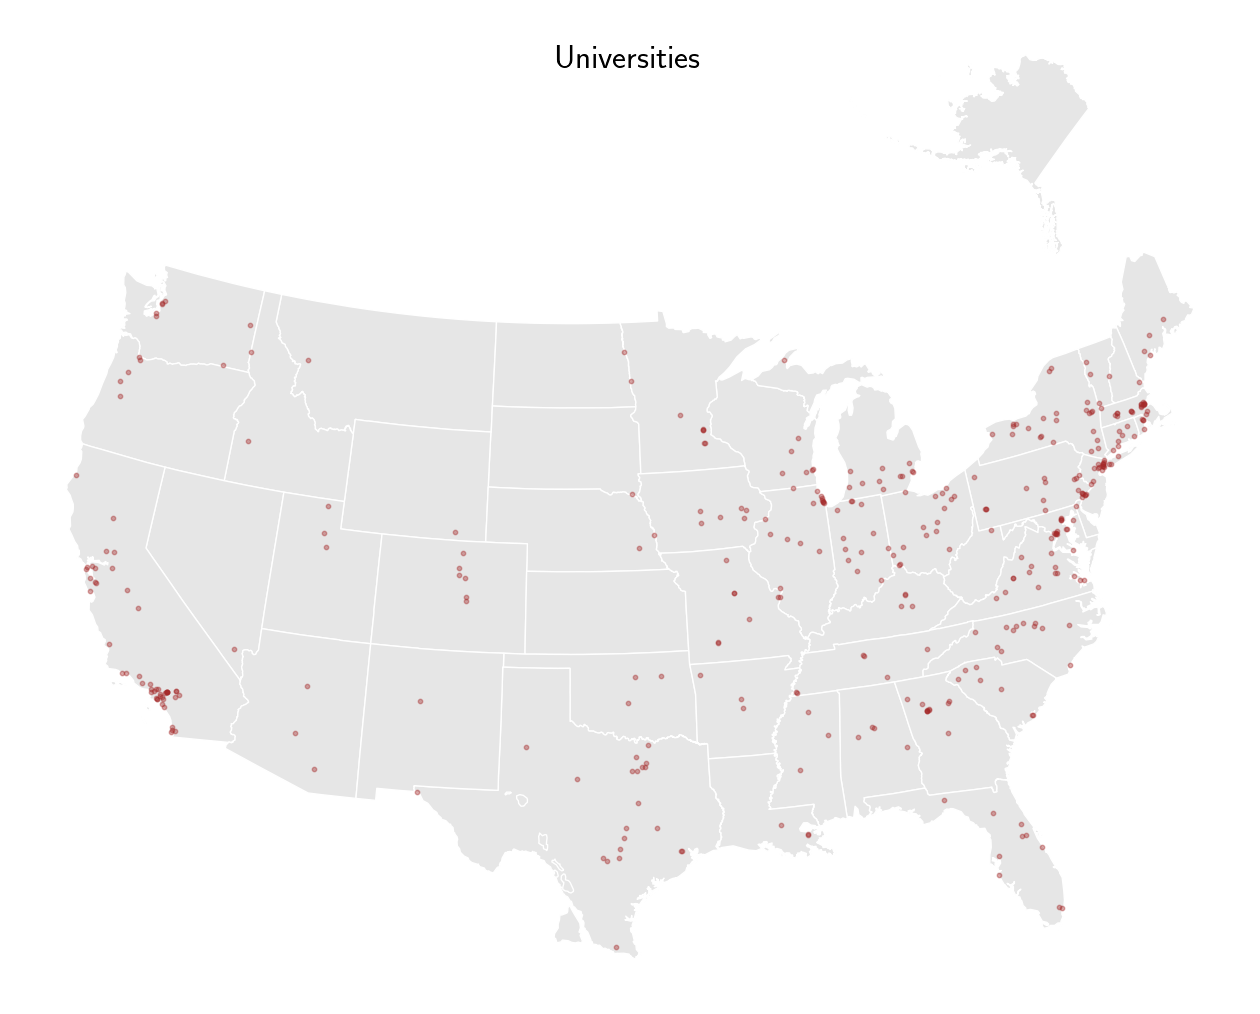

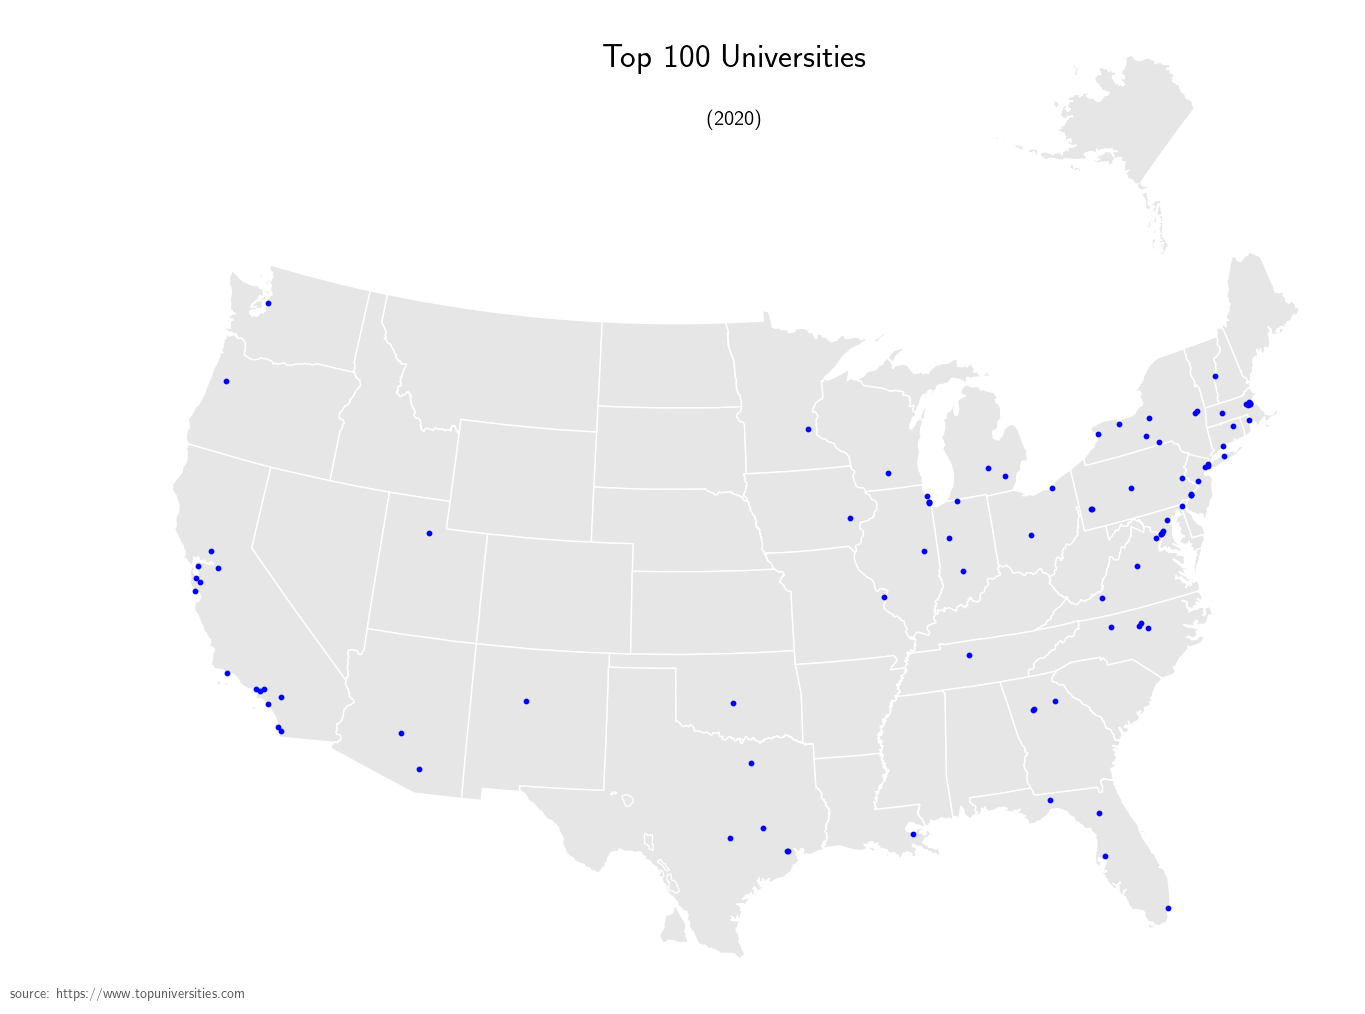

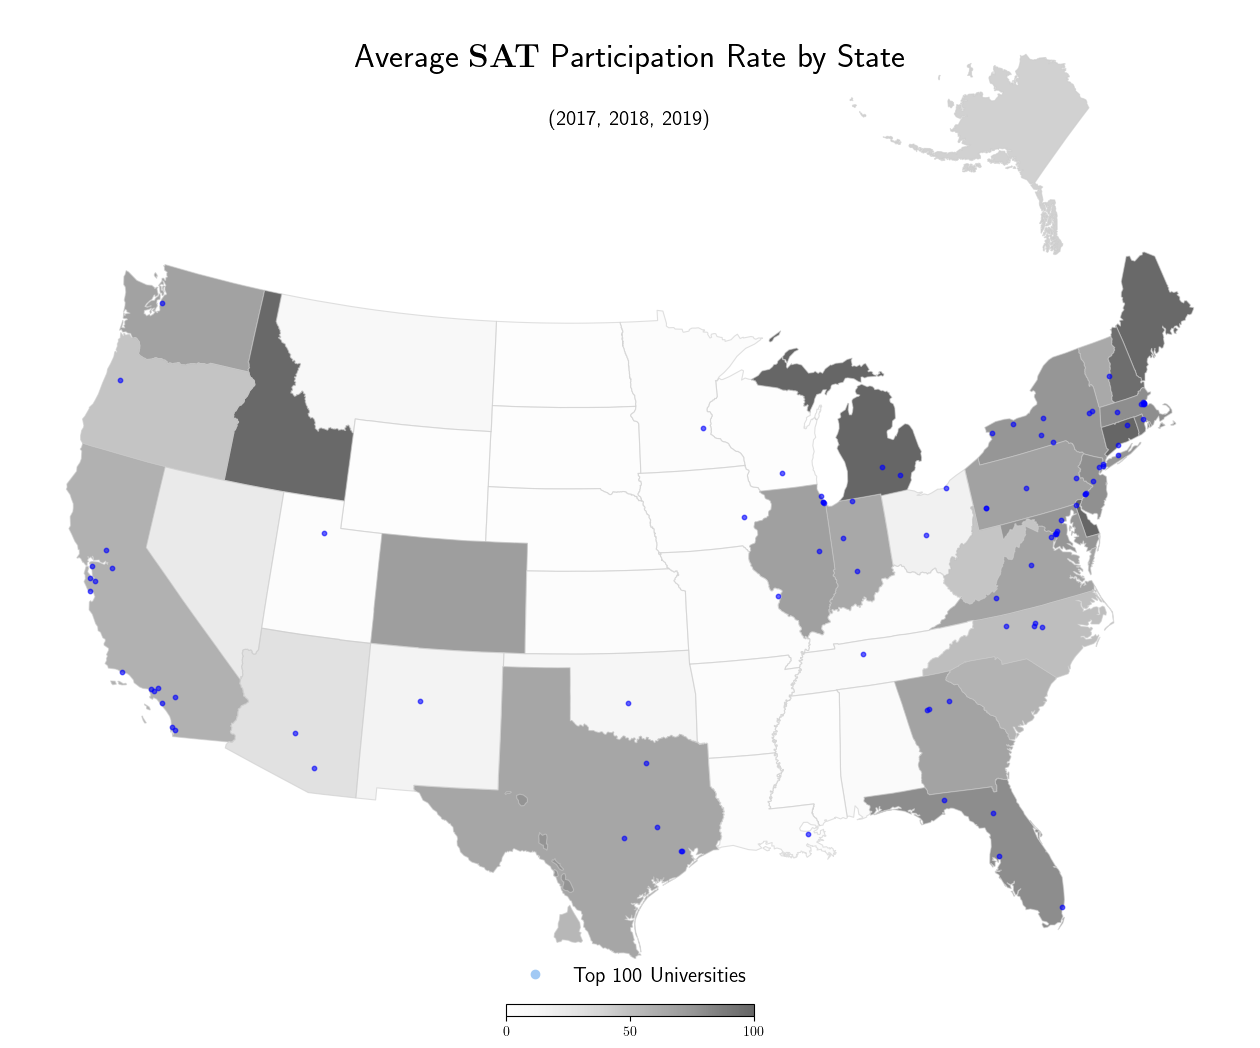

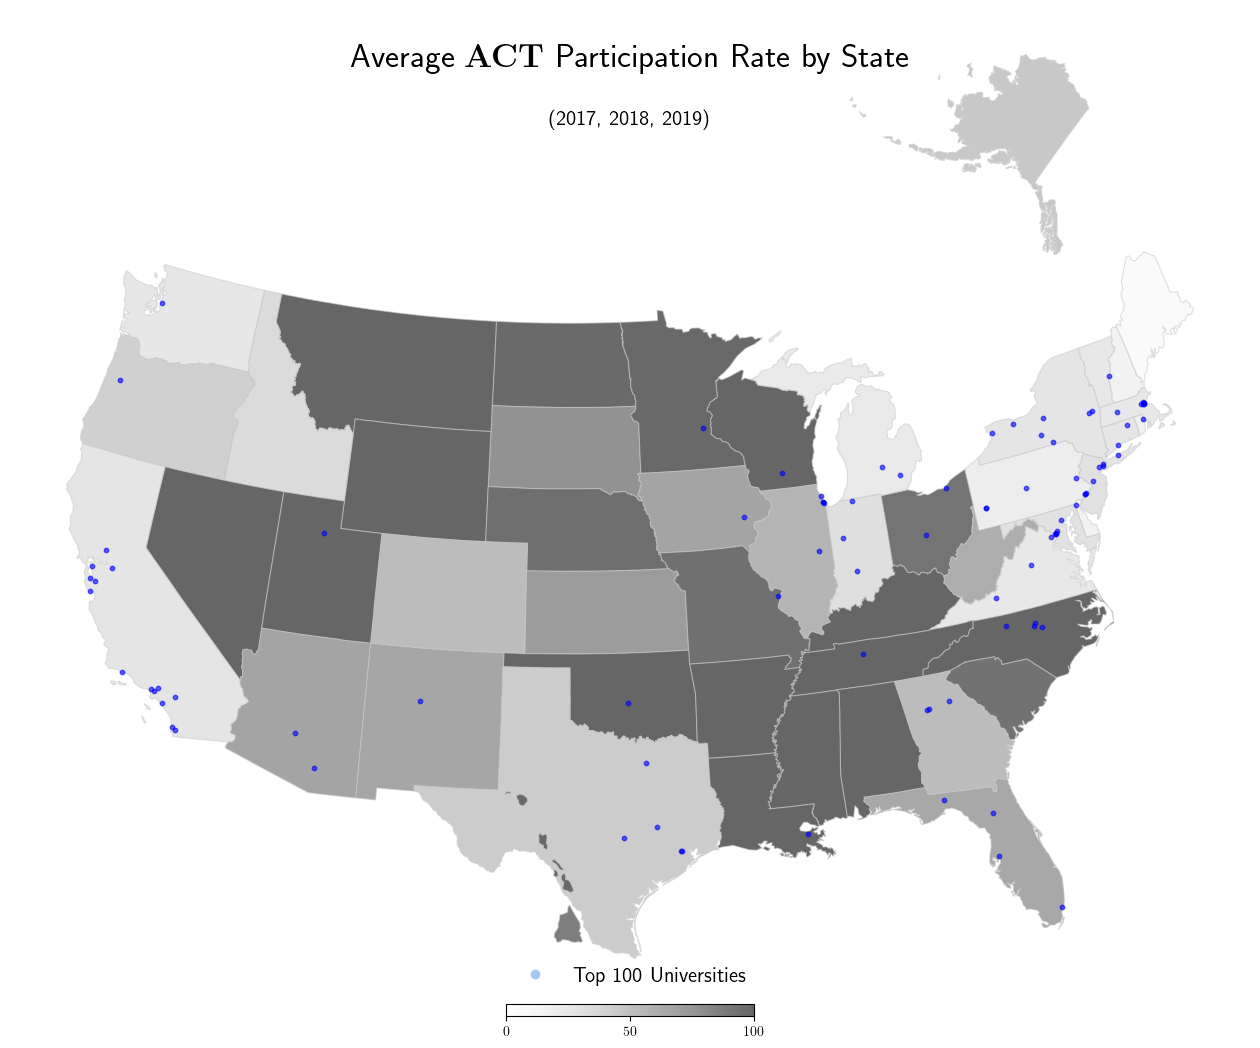

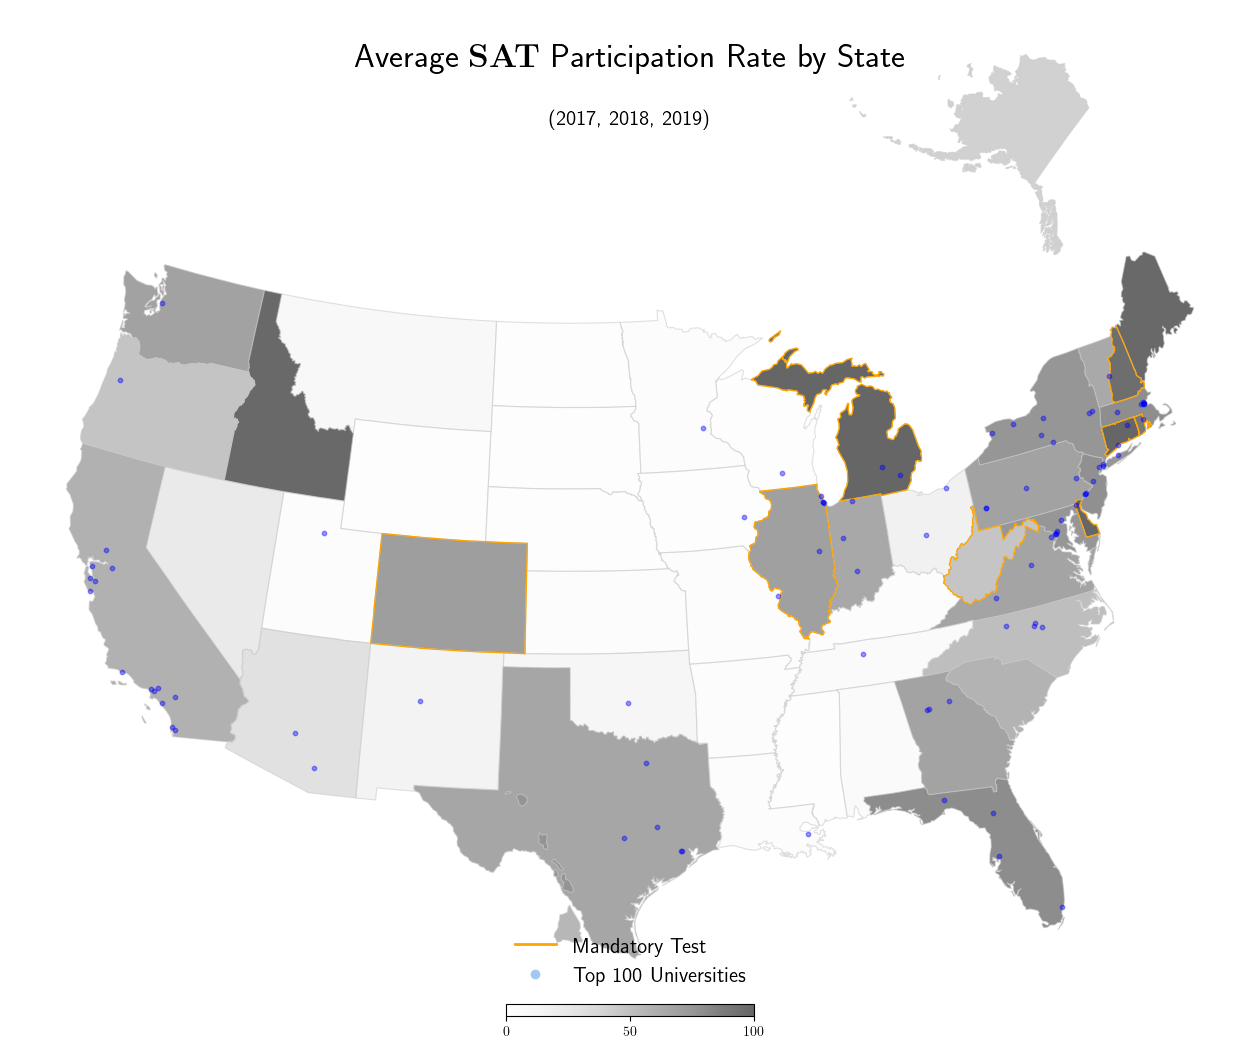

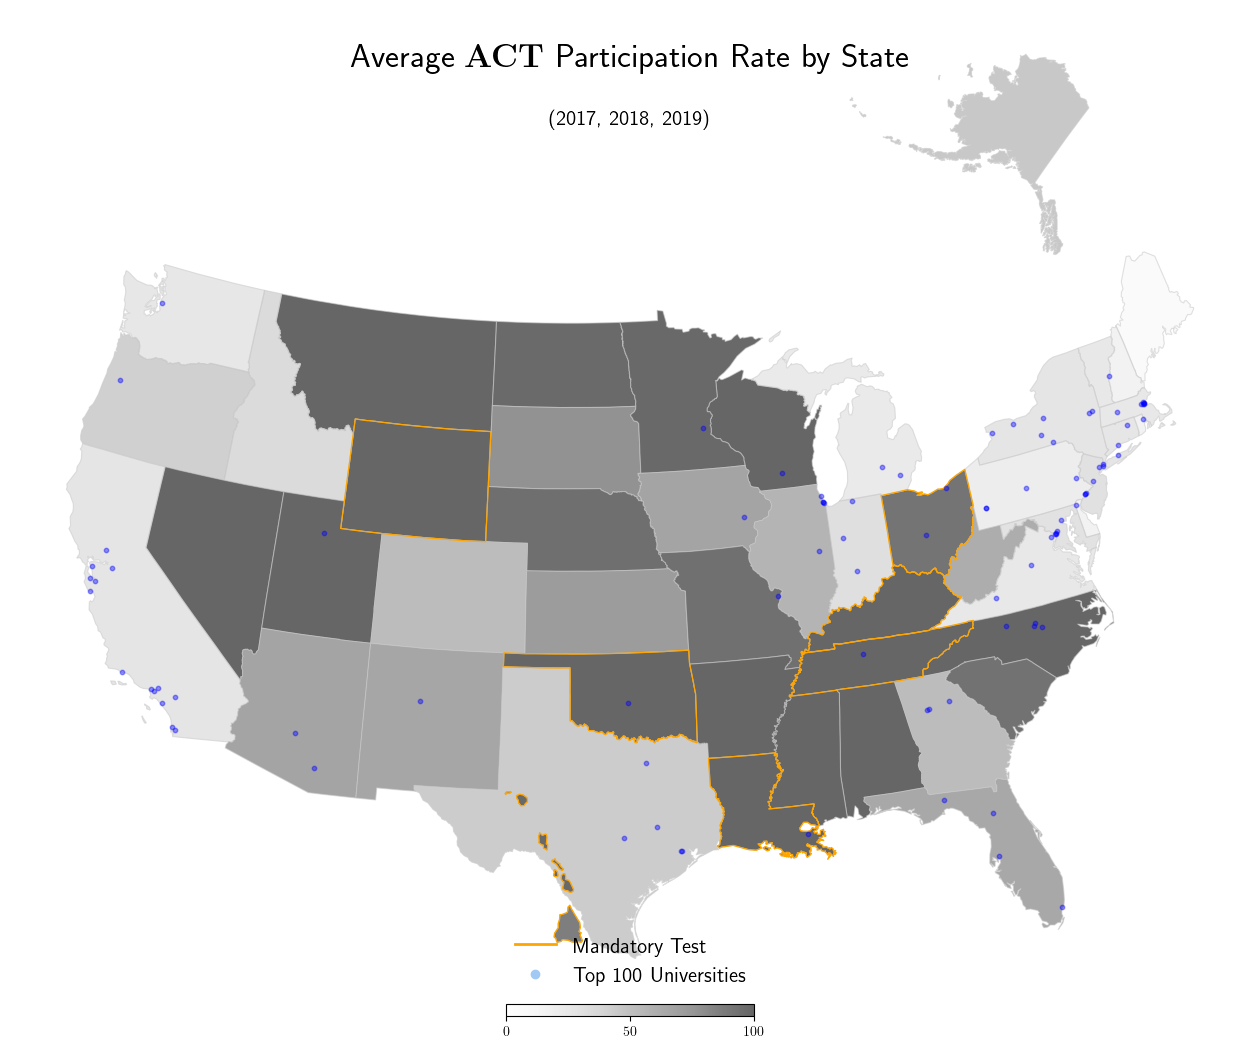

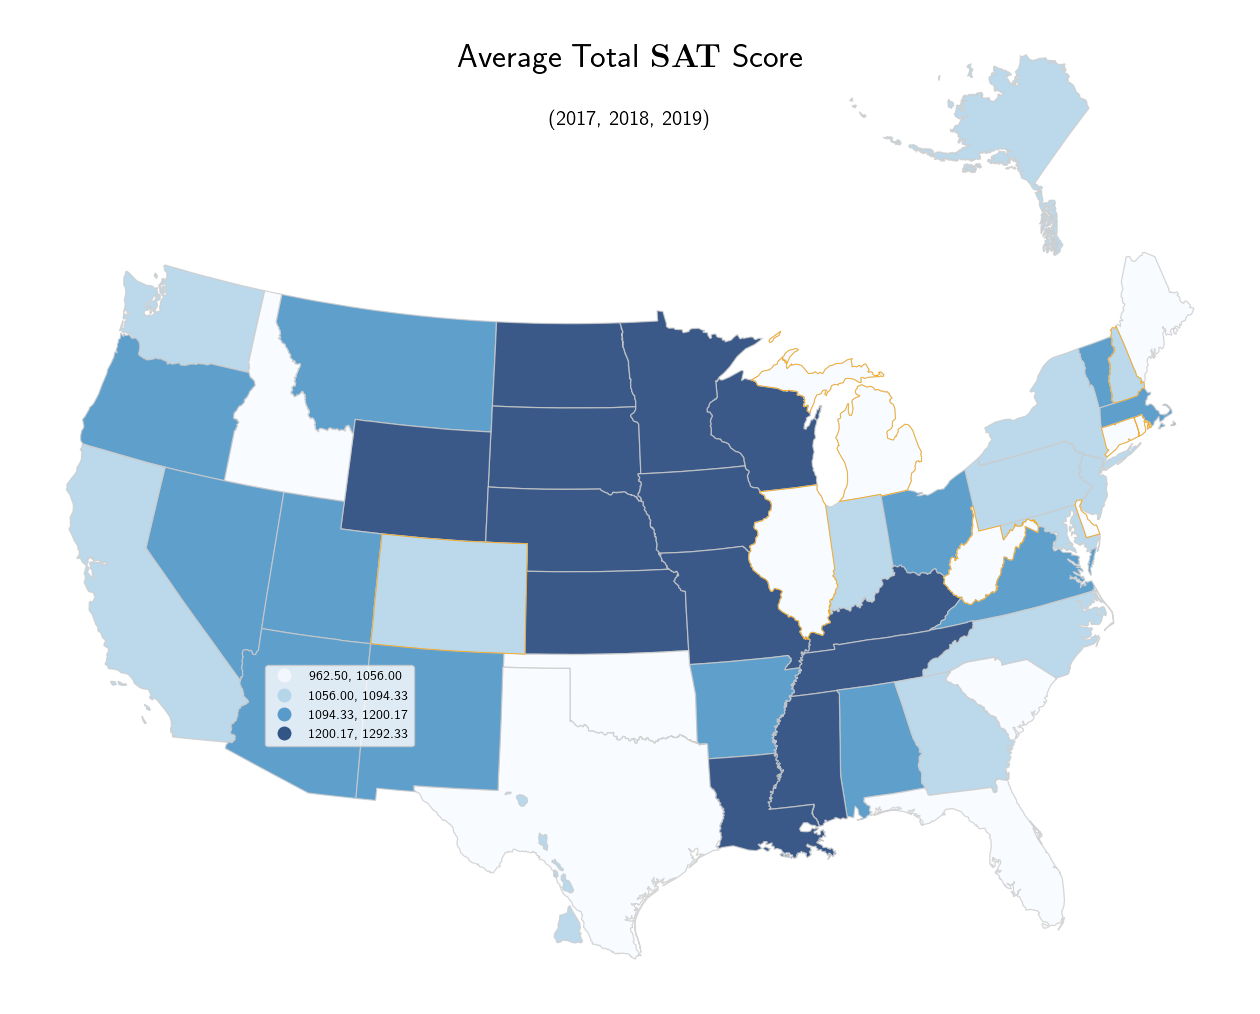

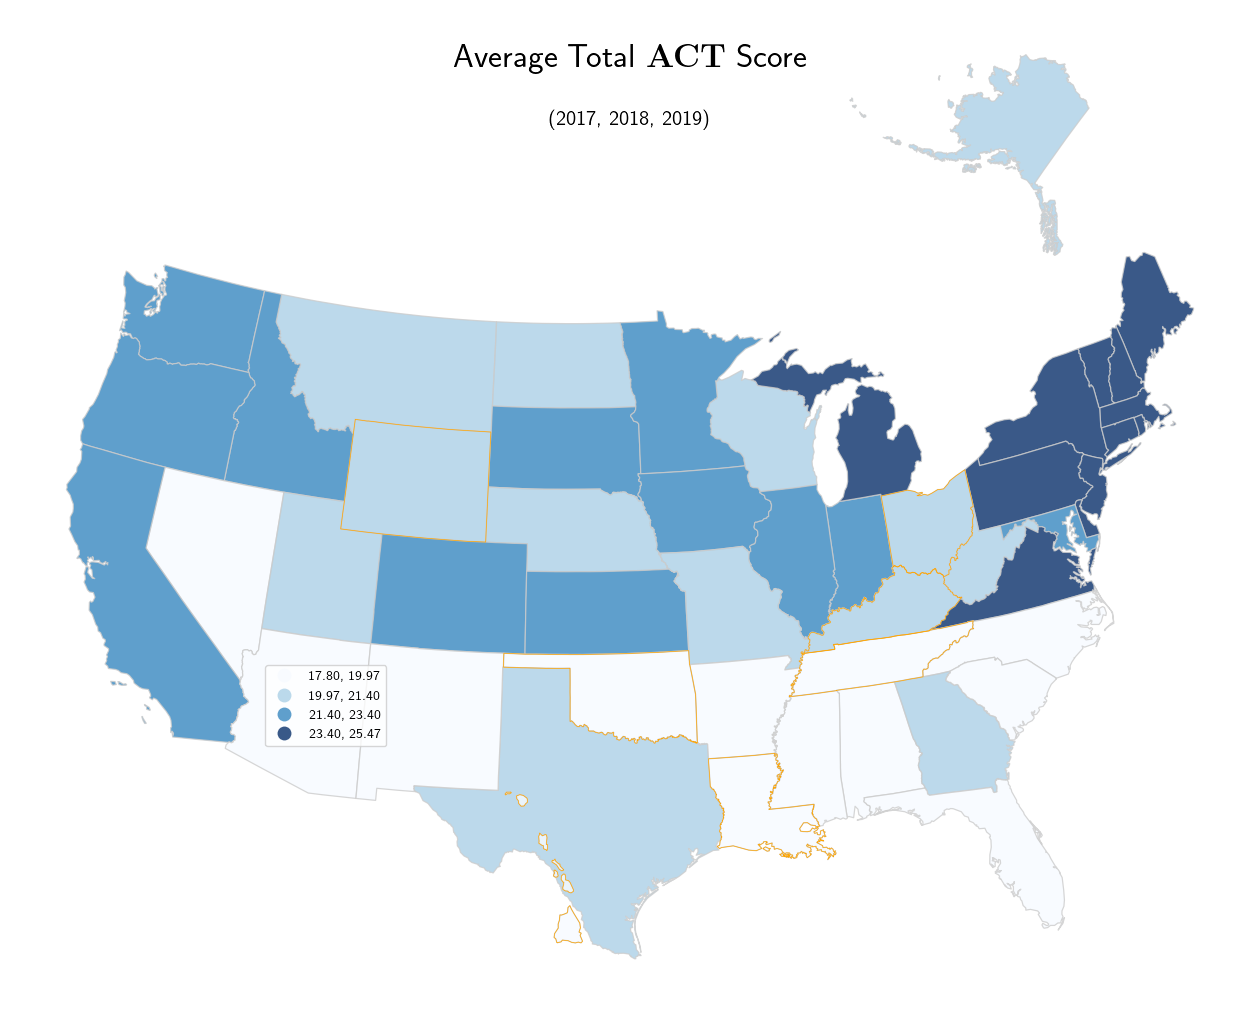

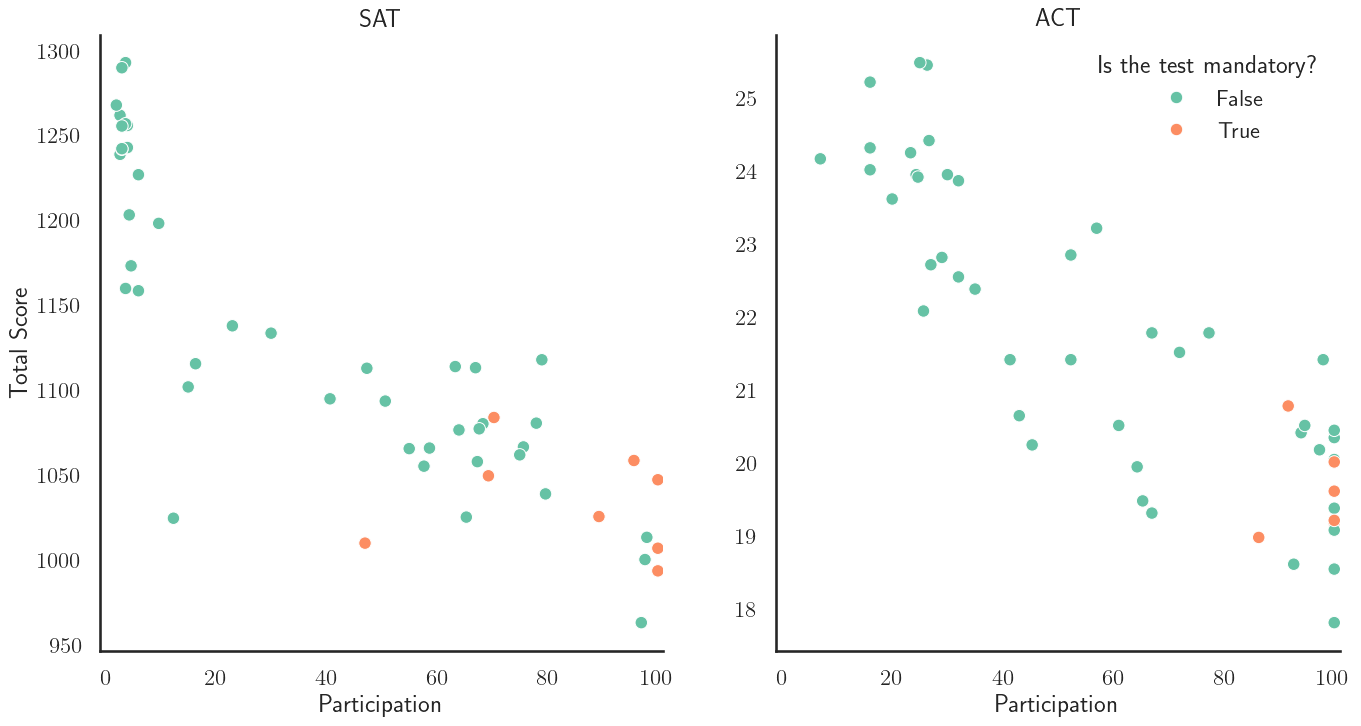

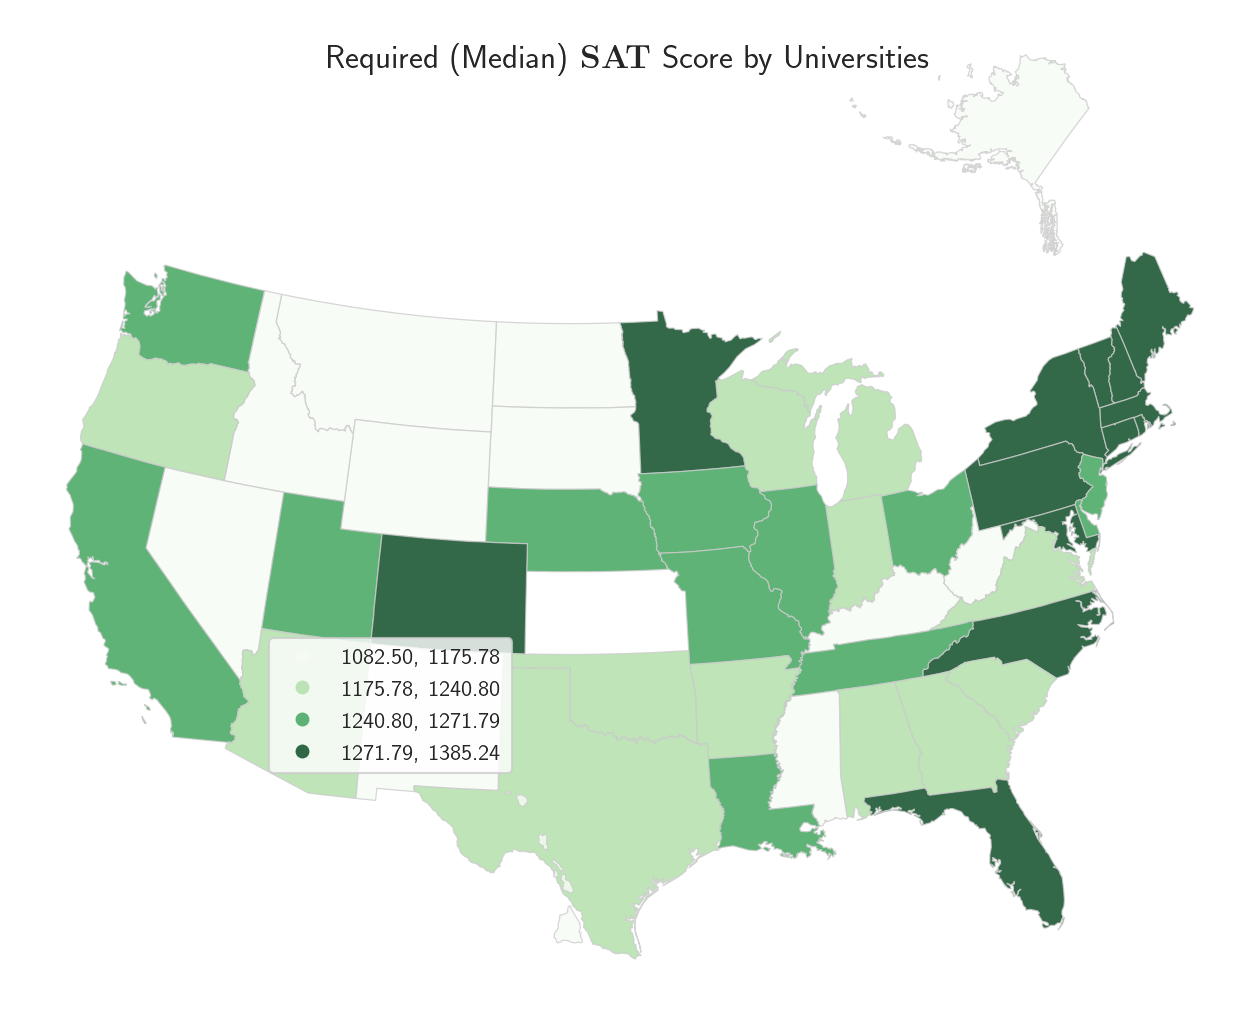

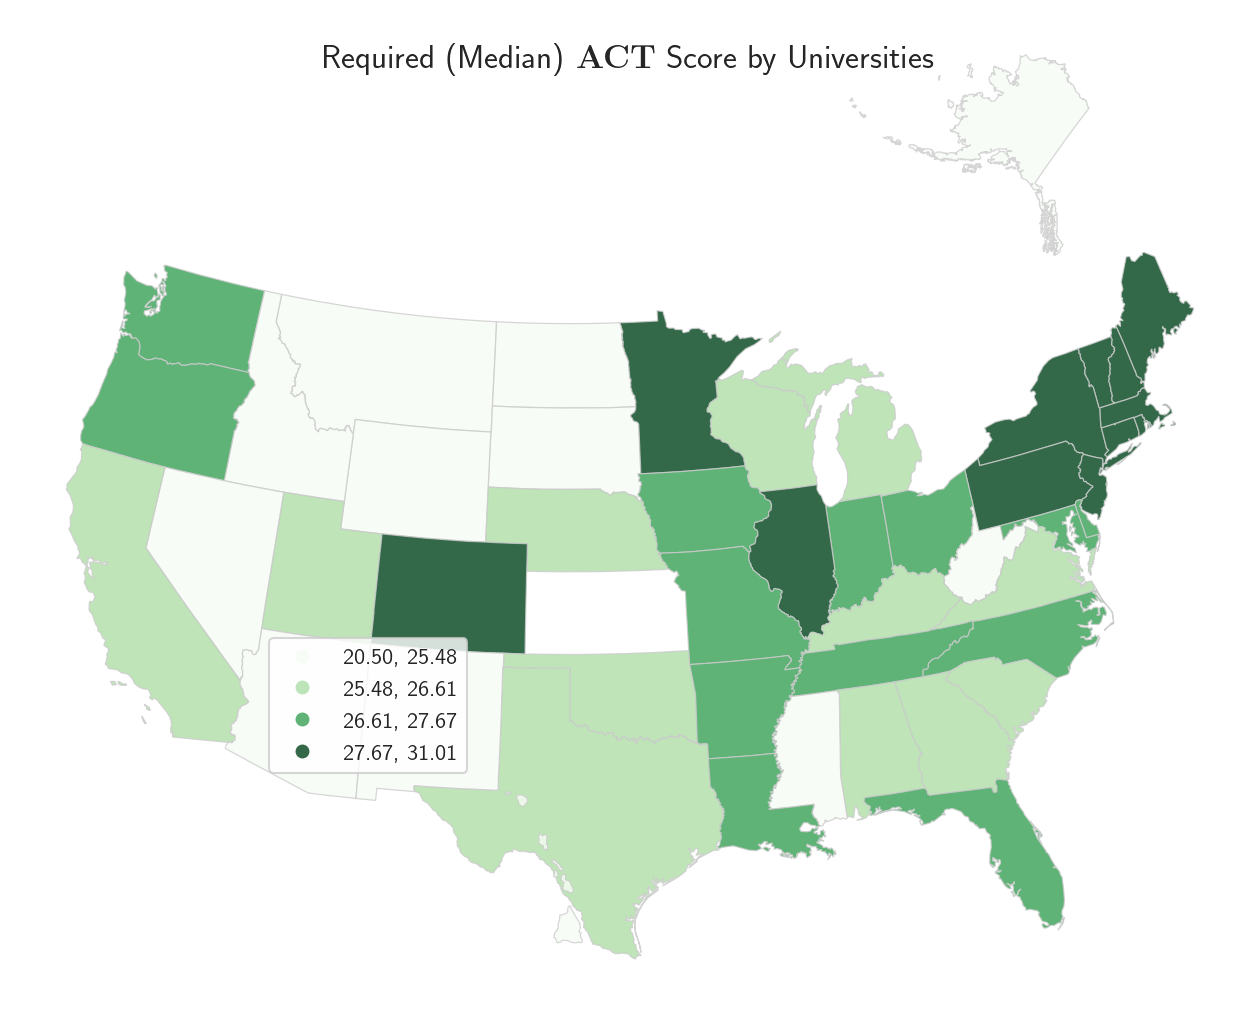

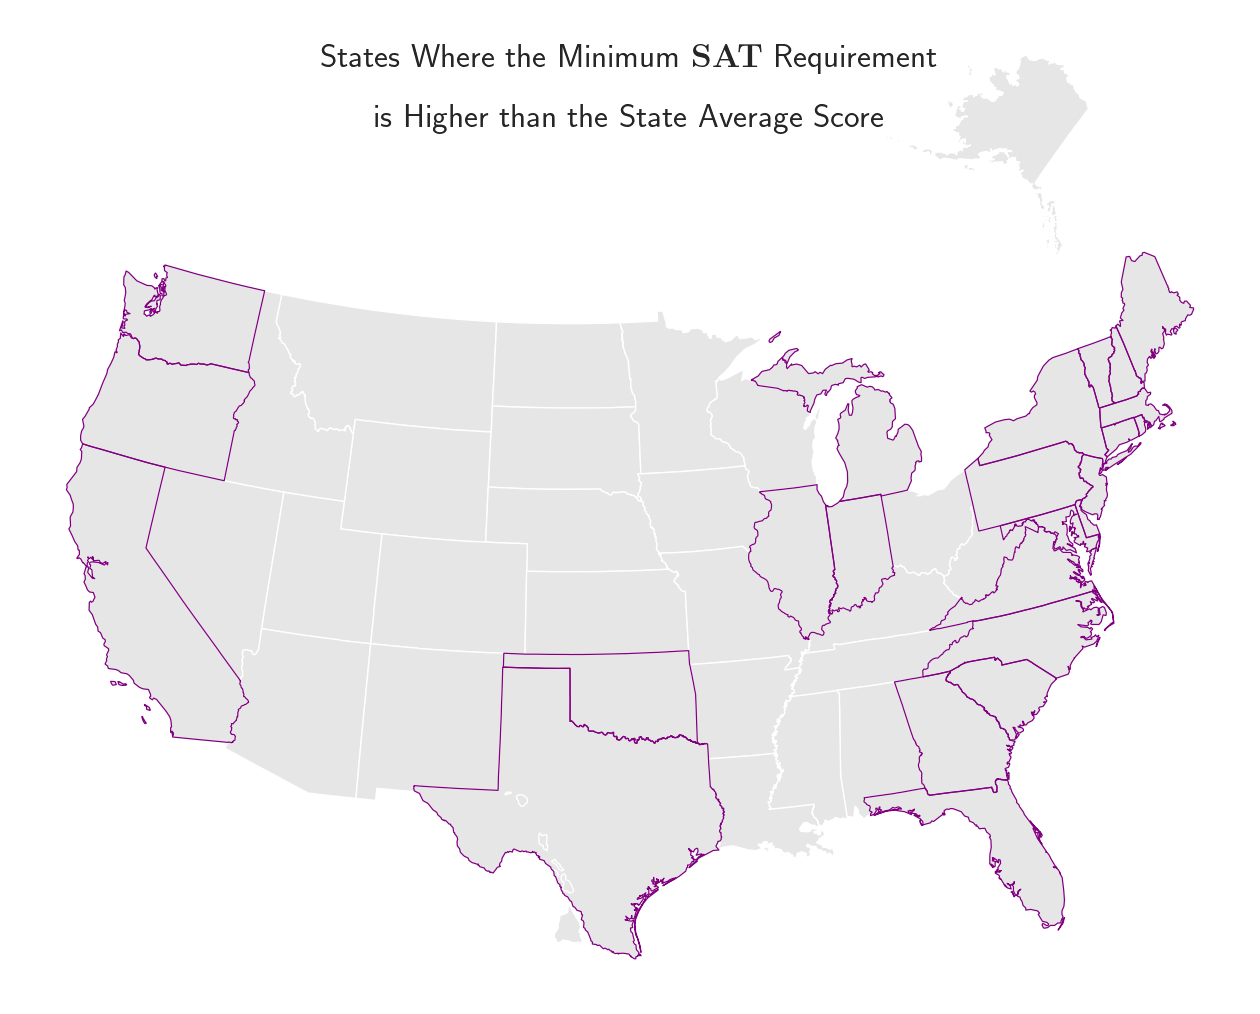

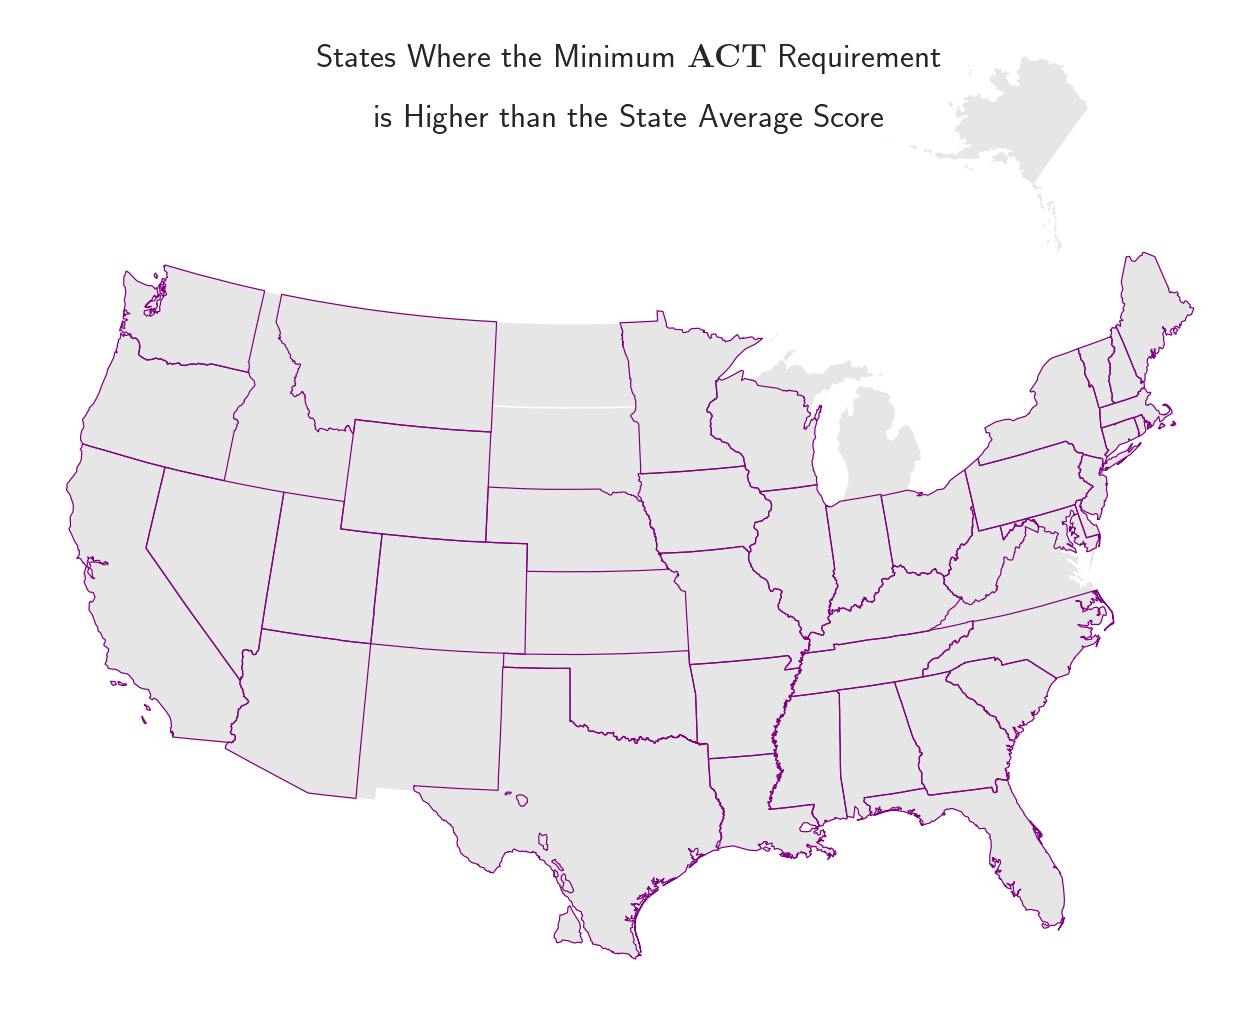

In [20]:
plot_all_universities_on_states(usa, geo_universities, to_save=True)
plot_top_ranking_universities_on_states(usa, geo_top_ranking, to_save=True)
plot_top_ranking_universities_layered_on_average_participation(act_and_sat_map, geo_top_ranking, test='sat', to_save=True)
plot_top_ranking_universities_layered_on_average_participation(act_and_sat_map, geo_top_ranking, test='act', to_save=True)
plot_top_ranking_universities_layered_on_average_participation_with_mandatory(act_and_sat_map, geo_top_ranking, test='sat', to_save=True)
plot_top_ranking_universities_layered_on_average_participation_with_mandatory(act_and_sat_map, geo_top_ranking, test='act', to_save=True)
average_score_with_mandatory(act_and_sat_map, test='sat', to_save=True)
average_score_with_mandatory(act_and_sat_map, test='act', to_save=True)
plot_scores_vs_participation(act_and_sat, to_save = True)
acceptance_scores_on_states(geo_acceptance_scores, test='sat', to_save=True)
acceptance_scores_on_states(geo_acceptance_scores, test='act', to_save=True)
map_states_with_higher_than_state_average_req(usa, geo_req_scores_state_avg, test='sat', to_save=True)
map_states_with_higher_than_state_average_req(usa, geo_req_scores_state_avg, test='act', to_save=True)

In [21]:
print(view_table_for_median_acceptance_scores(acceptance_scores, test = 'sat').to_markdown())

|    | state                |   sat_median |
|---:|:---------------------|-------------:|
|  0 | Massachusetts        |         1385 |
|  1 | Connecticut          |         1351 |
|  2 | Maine                |         1346 |
|  3 | Vermont              |         1341 |
|  4 | Pennsylvania         |         1337 |
|  5 | New Hampshire        |         1335 |
|  6 | Washington D.C.      |         1334 |
|  7 | Rhode Island         |         1318 |
|  8 | New York             |         1304 |
|  9 | Minnesota            |         1303 |
| 10 | Colorado             |         1295 |
| 11 | Maryland             |         1279 |
| 12 | Florida              |         1278 |
| 13 | North Carolina       |         1271 |
| 14 | Tennessee            |         1271 |
| 15 | Illinois             |         1265 |
| 16 | New Jersey           |         1264 |
| 17 | Louisiana            |         1263 |
| 18 | Delaware             |         1260 |
| 19 | Iowa                 |         1258 |
| 20 | Uta

In [22]:
print(view_table_for_median_acceptance_scores(acceptance_scores, test = 'act').to_markdown())

|    | state                |   act_median |
|---:|:---------------------|-------------:|
|  0 | Massachusetts        |         31   |
|  1 | Vermont              |         30.5 |
|  2 | Connecticut          |         30.1 |
|  3 | Maine                |         29.9 |
|  4 | Pennsylvania         |         29.6 |
|  5 | Washington D.C.      |         29.2 |
|  6 | New Hampshire        |         29.2 |
|  7 | Rhode Island         |         29.1 |
|  8 | Colorado             |         29   |
|  9 | New York             |         28.8 |
| 10 | Minnesota            |         28   |
| 11 | Illinois             |         27.9 |
| 12 | New Jersey           |         27.9 |
| 13 | Louisiana            |         27.7 |
| 14 | Tennessee            |         27.7 |
| 15 | Maryland             |         27.6 |
| 16 | Florida              |         27.6 |
| 17 | Delaware             |         27.5 |
| 18 | Arkansas             |         27.3 |
| 19 | Missouri             |         27.2 |
| 20 | Nor

In [23]:
print(view_table_for_state_and_participation_rates(act_and_sat, test='sat').to_markdown())

|    | state                |   sat % |
|---:|:---------------------|--------:|
|  0 | Michigan             |     100 |
|  1 | Connecticut          |     100 |
|  2 | Delaware             |     100 |
|  3 | Maine                |      98 |
|  4 | Idaho                |      97 |
|  5 | District of Columbia |      97 |
|  6 | New Hampshire        |      95 |
|  7 | Rhode Island         |      89 |
|  8 | Florida              |      79 |
|  9 | Massachusetts        |      79 |
| 10 | New Jersey           |      78 |
| 11 | Maryland             |      75 |
| 12 | New York             |      75 |
| 13 | Colorado             |      70 |
| 14 | Illinois             |      69 |
| 15 | Pennsylvania         |      68 |
| 16 | Washington           |      67 |
| 17 | Georgia              |      67 |
| 18 | Virginia             |      67 |
| 19 | Texas                |      65 |
| 20 | Indiana              |      64 |
| 21 | Vermont              |      63 |
| 22 | California           |      58 |


In [24]:
print(view_table_for_state_and_participation_rates(act_and_sat, test='act').to_markdown())

|    | state                |   act % |
|---:|:---------------------|--------:|
|  0 | Alabama              |     100 |
|  1 | Kentucky             |     100 |
|  2 | Wisconsin            |     100 |
|  3 | Utah                 |     100 |
|  4 | Tennessee            |     100 |
|  5 | Oklahoma             |     100 |
|  6 | North Carolina       |     100 |
|  7 | Nevada               |     100 |
|  8 | Montana              |     100 |
|  9 | Mississippi          |     100 |
| 10 | Louisiana            |     100 |
| 11 | Wyoming              |     100 |
| 12 | Arkansas             |     100 |
| 13 | Minnesota            |      98 |
| 14 | North Dakota         |      97 |
| 15 | Nebraska             |      94 |
| 16 | Missouri             |      94 |
| 17 | South Carolina       |      92 |
| 18 | Ohio                 |      91 |
| 19 | Hawaii               |      86 |
| 20 | South Dakota         |      77 |
| 21 | Kansas               |      72 |
| 22 | Iowa                 |      67 |


In [25]:
print(view_table_for_state_and_total_scores(act_and_sat, test='sat').to_markdown())

|    | state                |   sat_total |
|---:|:---------------------|------------:|
|  0 | Minnesota            |        1292 |
|  1 | Wisconsin            |        1289 |
|  2 | North Dakota         |        1267 |
|  3 | Iowa                 |        1261 |
|  4 | Missouri             |        1256 |
|  5 | Kansas               |        1255 |
|  6 | Nebraska             |        1255 |
|  7 | Kentucky             |        1242 |
|  8 | Wyoming              |        1241 |
|  9 | South Dakota         |        1241 |
| 10 | Mississippi          |        1238 |
| 11 | Tennessee            |        1226 |
| 12 | Louisiana            |        1202 |
| 13 | Montana              |        1197 |
| 14 | Arkansas             |        1172 |
| 15 | Utah                 |        1159 |
| 16 | Alabama              |        1158 |
| 17 | Nevada               |        1137 |
| 18 | Arizona              |        1133 |
| 19 | Massachusetts        |        1117 |
| 20 | Ohio                 |   

In [26]:
print(view_table_for_state_and_total_scores(act_and_sat, test='act').to_markdown())

|    | state                |   act_total |
|---:|:---------------------|------------:|
|  0 | Massachusetts        |        25.5 |
|  1 | Connecticut          |        25.4 |
|  2 | New Hampshire        |        25.2 |
|  3 | New York             |        24.4 |
|  4 | Rhode Island         |        24.3 |
|  5 | Michigan             |        24.2 |
|  6 | Maine                |        24.2 |
|  7 | Delaware             |        24   |
|  8 | Vermont              |        23.9 |
|  9 | New Jersey           |        23.9 |
| 10 | Virginia             |        23.9 |
| 11 | District of Columbia |        23.8 |
| 12 | Pennsylvania         |        23.6 |
| 13 | Illinois             |        23.2 |
| 14 | Colorado             |        22.8 |
| 15 | Maryland             |        22.8 |
| 16 | California           |        22.7 |
| 17 | Indiana              |        22.5 |
| 18 | Idaho                |        22.4 |
| 19 | Washington           |        22.1 |
| 20 | South Dakota         |   

In [27]:
print(get_counts_for_high_ranking_universities_per_state().to_markdown())

| state           |   count |
|:----------------|--------:|
| California      |      14 |
| New York        |      10 |
| Massachusetts   |       8 |
| Pennsylvania    |       7 |
| Illinois        |       5 |
| Texas           |       5 |
| New Jersey      |       4 |
| North Carolina  |       4 |
| Florida         |       4 |
| Indiana         |       3 |
| Virginia        |       3 |
| Washington D.C. |       3 |
| Georgia         |       3 |
| Connecticut     |       2 |
| Michigan        |       2 |
| Ohio            |       2 |
| Maryland        |       2 |
| Arizona         |       2 |
| New Mexico      |       1 |
| Hawaii          |       1 |
| Delaware        |       1 |
| Oregon          |       1 |
| Iowa            |       1 |
| Utah            |       1 |
| Louisiana       |       1 |
| Tennessee       |       1 |
| Wisconsin       |       1 |
| Minnesota       |       1 |
| New Hampshire   |       1 |
| Missouri        |       1 |
| Washington      |       1 |
| Rhode Is

In [28]:
print(get_states_where_colleges_require_higher_score_than_average(test='sat').to_markdown())

|    | state          |
|---:|:---------------|
|  0 | California     |
|  1 | Connecticut    |
|  2 | Delaware       |
|  3 | Florida        |
|  4 | Georgia        |
|  5 | Illinois       |
|  6 | Indiana        |
|  7 | Maine          |
|  8 | Maryland       |
|  9 | Massachusetts  |
| 10 | Michigan       |
| 11 | New Hampshire  |
| 12 | New Jersey     |
| 13 | New York       |
| 14 | North Carolina |
| 15 | Oklahoma       |
| 16 | Oregon         |
| 17 | Pennsylvania   |
| 18 | Rhode Island   |
| 19 | South Carolina |
| 20 | Texas          |
| 21 | Vermont        |
| 22 | Virginia       |
| 23 | Washington     |


In [29]:
print(get_states_where_colleges_require_higher_score_than_average(test='act').to_markdown())

|    | state          |
|---:|:---------------|
|  0 | Alabama        |
|  1 | Arizona        |
|  2 | Arkansas       |
|  3 | California     |
|  4 | Colorado       |
|  5 | Connecticut    |
|  6 | Delaware       |
|  7 | Florida        |
|  8 | Georgia        |
|  9 | Hawaii         |
| 10 | Illinois       |
| 11 | Indiana        |
| 12 | Iowa           |
| 13 | Kentucky       |
| 14 | Louisiana      |
| 15 | Maine          |
| 16 | Maryland       |
| 17 | Massachusetts  |
| 18 | Minnesota      |
| 19 | Mississippi    |
| 20 | Missouri       |
| 21 | Montana        |
| 22 | Nebraska       |
| 23 | Nevada         |
| 24 | New Hampshire  |
| 25 | New Jersey     |
| 26 | New York       |
| 27 | North Carolina |
| 28 | Ohio           |
| 29 | Oklahoma       |
| 30 | Oregon         |
| 31 | Pennsylvania   |
| 32 | Rhode Island   |
| 33 | South Carolina |
| 34 | Tennessee      |
| 35 | Texas          |
| 36 | Utah           |
| 37 | Vermont        |
| 38 | Washington     |
| 39 | West Virg

In [30]:
print(get_states_where_colleges_require_higher_score_than_average(test='sat').to_markdown())

|    | state          |
|---:|:---------------|
|  0 | California     |
|  1 | Connecticut    |
|  2 | Delaware       |
|  3 | Florida        |
|  4 | Georgia        |
|  5 | Illinois       |
|  6 | Indiana        |
|  7 | Maine          |
|  8 | Maryland       |
|  9 | Massachusetts  |
| 10 | Michigan       |
| 11 | New Hampshire  |
| 12 | New Jersey     |
| 13 | New York       |
| 14 | North Carolina |
| 15 | Oklahoma       |
| 16 | Oregon         |
| 17 | Pennsylvania   |
| 18 | Rhode Island   |
| 19 | South Carolina |
| 20 | Texas          |
| 21 | Vermont        |
| 22 | Virginia       |
| 23 | Washington     |
